**Analysis of Indent Simulation**

In this notebook, I will run and analyze a basic indent simulation from the LAMMPS example scripts.
 - Chart the path of an atom
 - Generate an ROB
 - Graph the eigenvalue error
 - Repeat for multiple potentials

Notes
 - Only works for higher orders, starting at between 20 and 50

In [39]:
# import libraries

import numpy as np
from lammps import lammps
import matplotlib.pyplot as plt
from dump import dump

In [40]:
# toggle runs

full_model_flag = False
generate_basis_flag = False
reduced_order_model_flag = True

In [41]:
# set file names and paths

potential = "lj"
potentials = ["lj"]

phi_format = "rob/phi_{}.txt"
phi_file = phi_format.format(potential)
dump_full_model = f"dump/dump.indent_{potential}"
dump_reduced_model = f"dump/dump.indent_rom_{potential}"

In [42]:
# set reduced order models

orders = [50]

In [43]:
# create runs

def run_sim(fix_commands, dump_command="", run_command=""):
  lmp = lammps()
  lmp.file(f"in.indent")
  lmp.commands_list(fix_commands)
  lmp.commands_string(
    f"""
      # run with indenter

      timestep	0.003
      variable	k equal 1000.0/xlat
      variable        y equal "13.0*ylat - step*dt*0.02*ylat"

      fix		4 all indent $k sphere 10 v_y 0 5.0
      fix		5 all enforce2d

      thermo		1000
      thermo_modify	temp new

    """
  )
  
  lmp.command(dump_command)
  lmp.command(run_command)

def run_full_model(generate_basis_flag):
  fix_commands = ["fix 1 all nve", "fix 2 lower setforce 0.0 0.0 0.0", "fix 3 all temp/rescale 100 0.1 0.1 0.01 1.0"]
  if generate_basis_flag: fix_commands.append(f"fix 6 all rob 50 full {phi_file}")
  run_sim(fix_commands,
          dump_command = f"dump 1 all custom 300 {dump_full_model} id type x y z",
          run_command = "run 30000")

def run_reduced_order_model(n):
  fix_commands = [f"fix 1 all nve/rom {n} {phi_file}", "fix 2 lower setforce 0.0 0.0 0.0", "fix 3 all temp/rescale 100 0.1 0.1 0.01 1.0", "fix extra all ave/time 300 1 300 f_1 mode vector file dump.test"]
  run_sim(fix_commands,
          dump_command = f"dump 1 all custom 300 {dump_reduced_model}_{n} id type x y z",
          run_command = "run 30000")

In [44]:
# run sims

if full_model_flag: run_full_model(generate_basis_flag)
if reduced_order_model_flag:
  for n in orders:
    run_reduced_order_model(n)

LAMMPS (28 Mar 2023 - Development)
Lattice spacing in x,y,z = 1.1326962 1.9618873 1.1326962
Created orthogonal box = (0 0 -0.28317404) to (22.653923 19.618873 0.28317404)
  1 by 1 by 1 MPI processor grid
Created 420 atoms
  using lattice units in orthogonal box = (0 -0.0019618873 -0.28317404) to (22.653923 19.620835 0.28317404)
  create_atoms CPU = 0.000 seconds
60 atoms in group lower
360 atoms in group mobile
Setting atom values ...
  60 settings made for type
Reading reduced-order basis file rob/phi_lj.txt
Generated 0 of 1 mixed pair_coeff terms from geometric mixing rule
Neighbor list info ...
  update: every = 1 steps, delay = 5 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 2.8
  ghost atom cutoff = 2.8
  binsize = 1.4, bins = 17 15 1
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair lj/cut, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/2d
      bin: 

      1000   0.11671309    -3.066064       0             -2.9663021      1.6367236      427.98647    
      2000   0.11087216    -3.0624959      0             -2.9677266     -1.4995832      456.3345     
      3000   0.10516886    -3.1207806      0             -3.0308863      0.075773271    439.56729    
      4000   0.11660566    -3.129278       0             -3.0296079     -0.63449347     441.19754    
      5000   0.12351857    -3.1030326      0             -2.9974537     -0.58184496     445.94542    
      6000   0.11671309    -3.0724423      0             -2.9726804      0.37281346     441.14943    
      7000   0.11671309    -3.1110847      0             -3.0113228     -0.35397639     443.69228    
      8000   0.11671309    -3.096263       0             -2.9965011      0.41077487     438.10151    
      9000   0.11671309    -3.0627846      0             -2.9630227     -0.0081909014   444.70377    
     10000   0.12451355    -3.0705644      0             -2.9641349      1.0303369

In [45]:
# read dump files

models = dict()

models['full'] = dump(dump_full_model)
models['full'].sort()


for n in orders:
  models[f"reduced_{n}"] = dump(dump_reduced_model + f"_{n}")
  models[f"reduced_{n}"].sort()

read 101 snapshots
101 snapshots selected out of 101
assigned columns: id type x y z 
dump is already unscaled
Sorting selected snapshots ...
read 101 snapshots
101 snapshots selected out of 101
assigned columns: id type x y z 
dump is already unscaled
Sorting selected snapshots ...


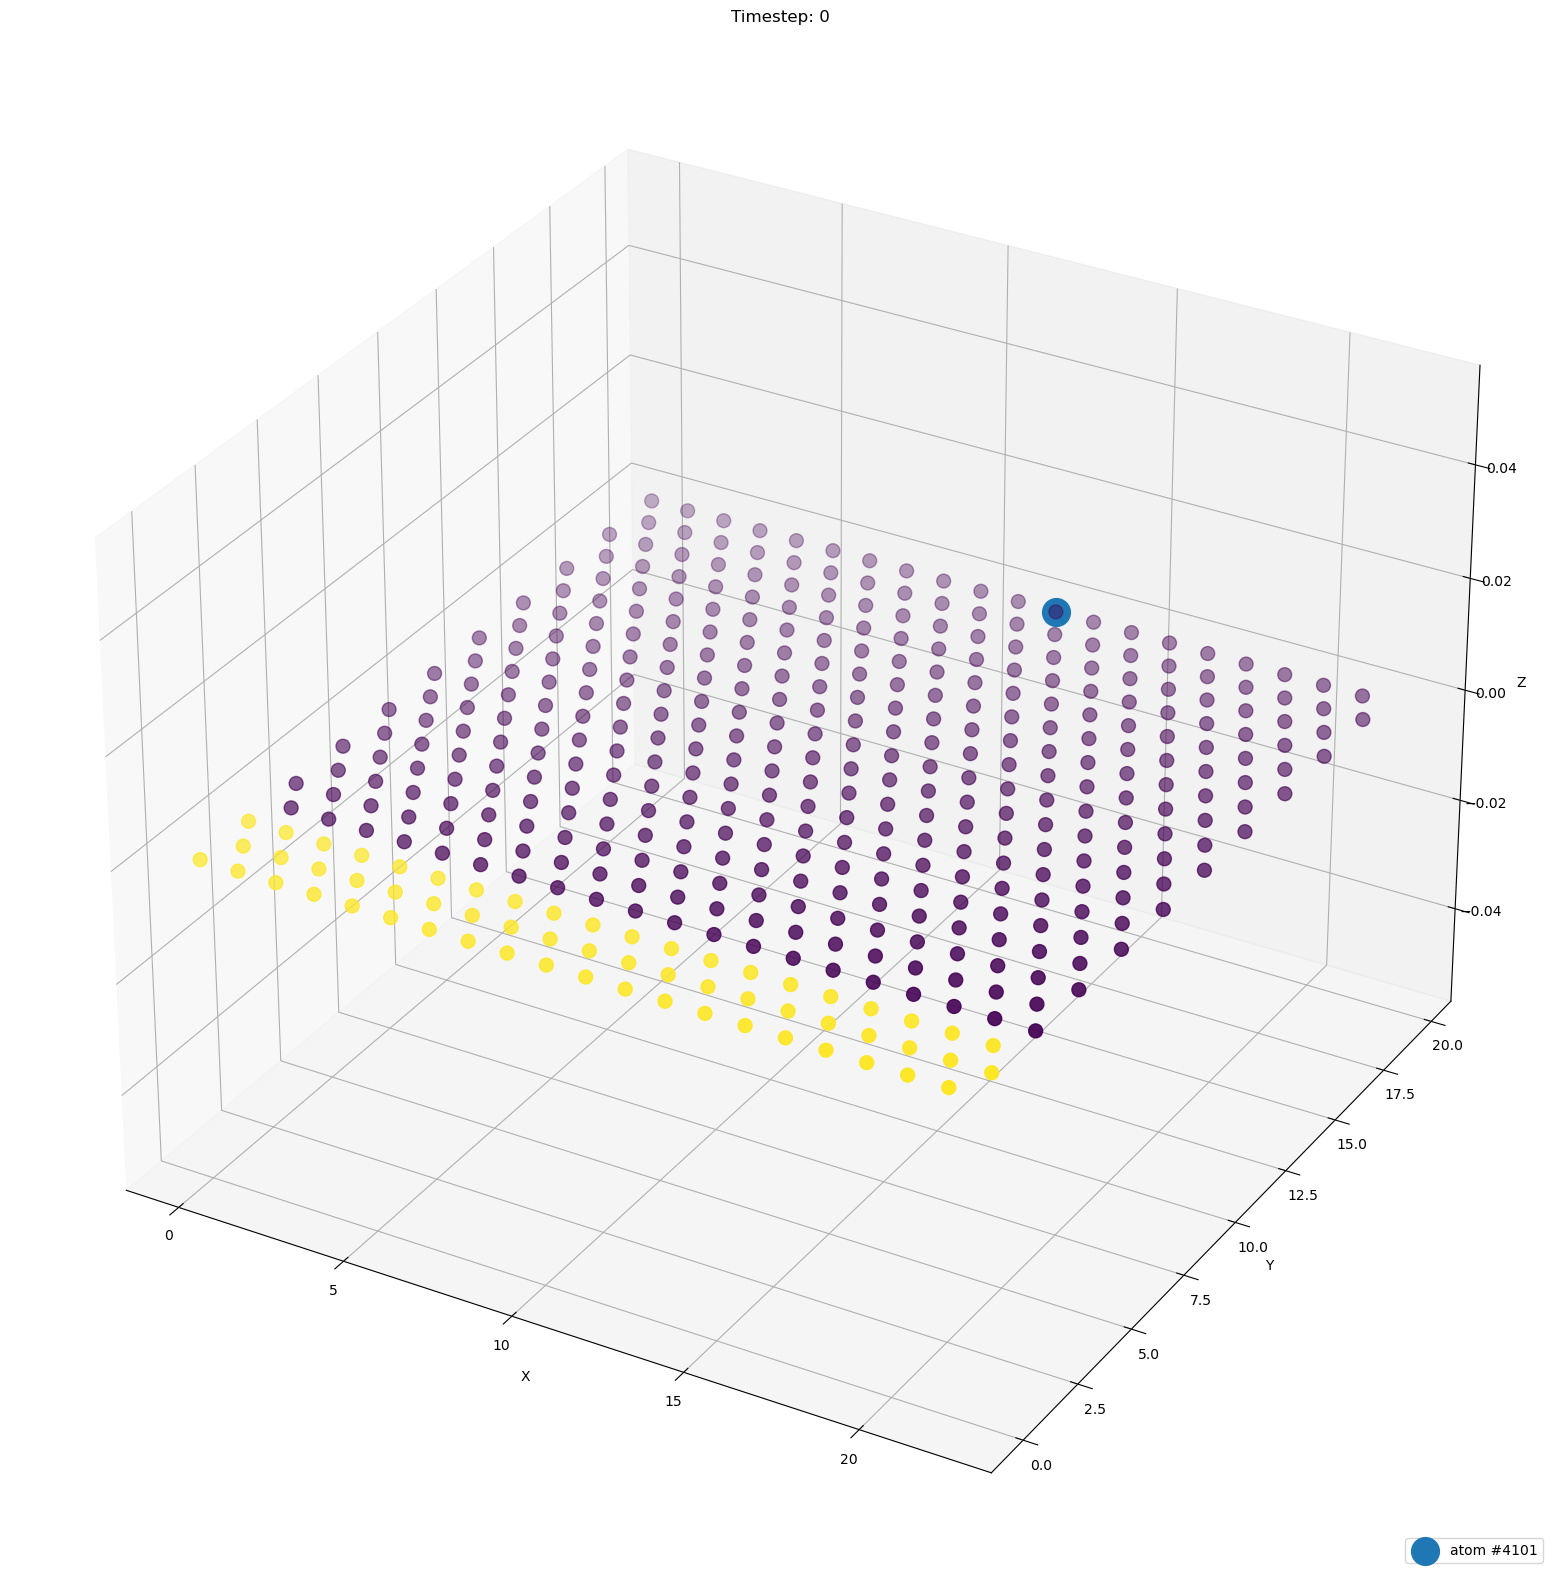

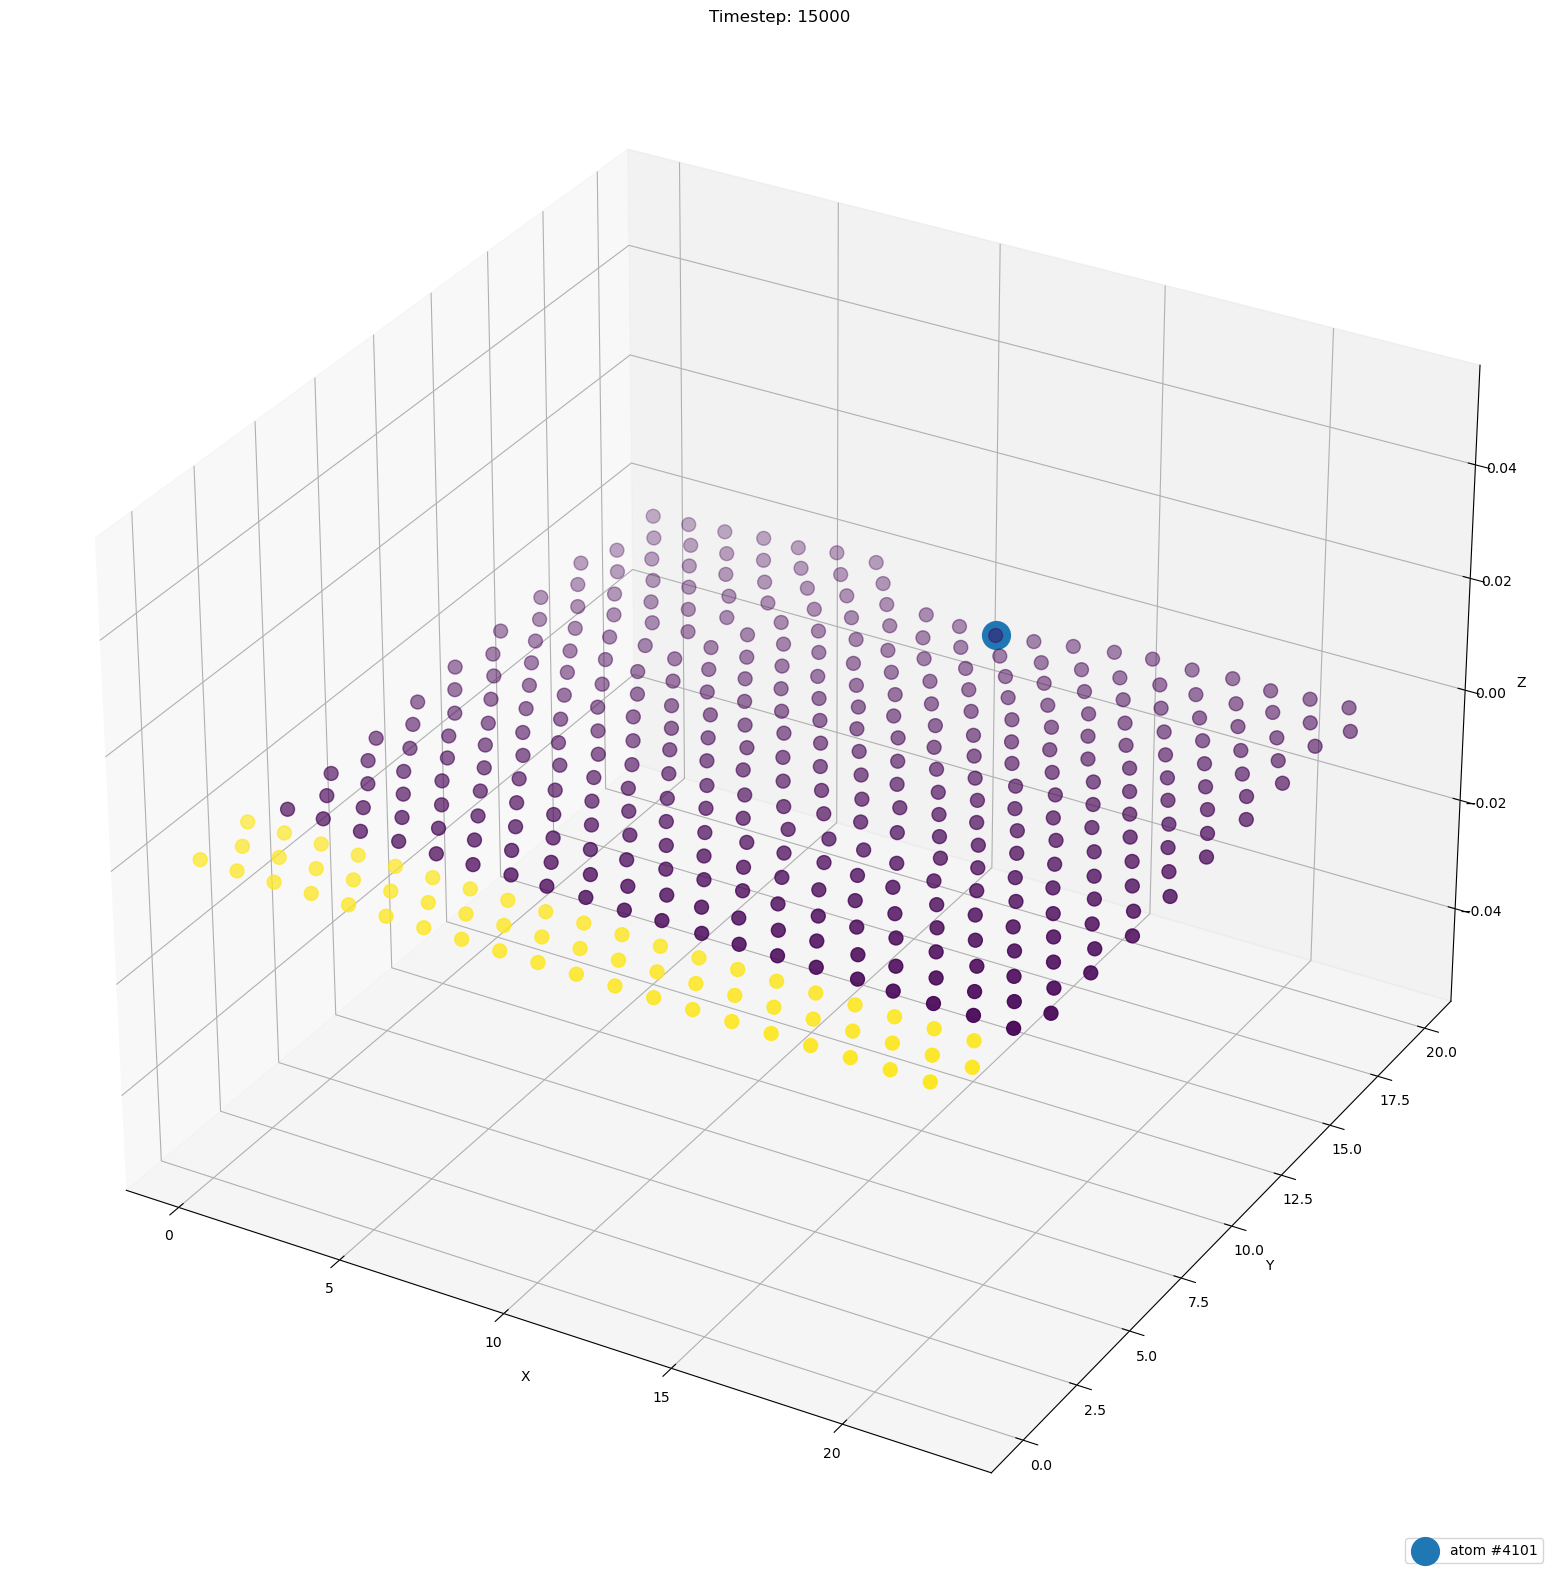

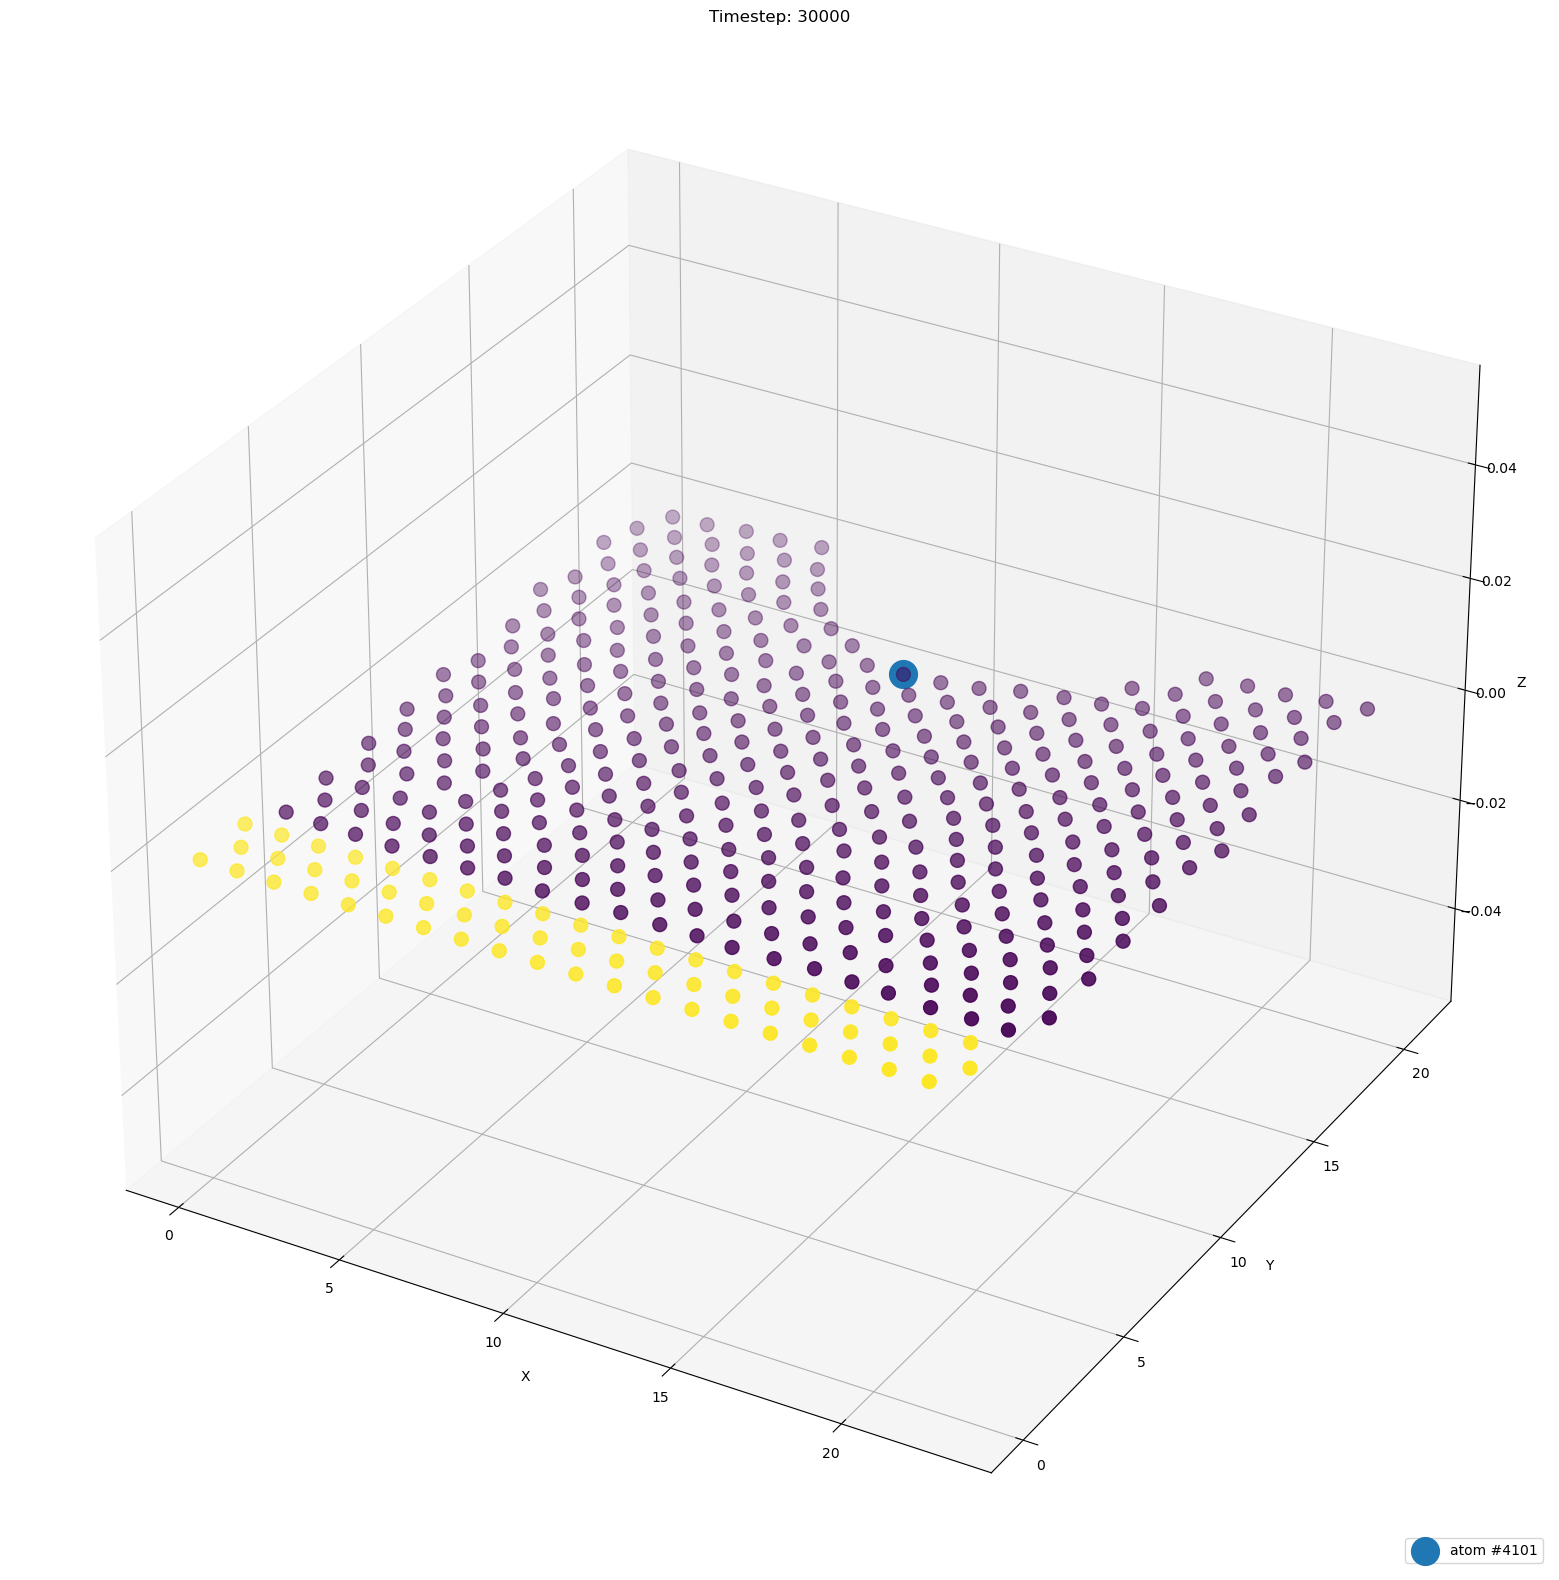

In [46]:
# graph snapshot positions

a = 411 # select an atom
snapshots_indices = [0, 50, 100]

for i in snapshots_indices:

  t = models['full'].time()[i]

  atoms = models['full'].vecs(t,"type","x","y","z", "id")

  fig = plt.figure(figsize=(30,20))
  ax = fig.add_subplot(projection = '3d')
  ax.scatter(atoms[1], atoms[2], atoms[3], c=atoms[0], s=100)
  atom = ax.scatter(atoms[1][a], atoms[2][a], atoms[3][a], s=400)

  ax.set_title(f"Timestep: {t}")
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')

  plt.legend([atom], ["atom #4101"], loc="lower right")

  plt.show()

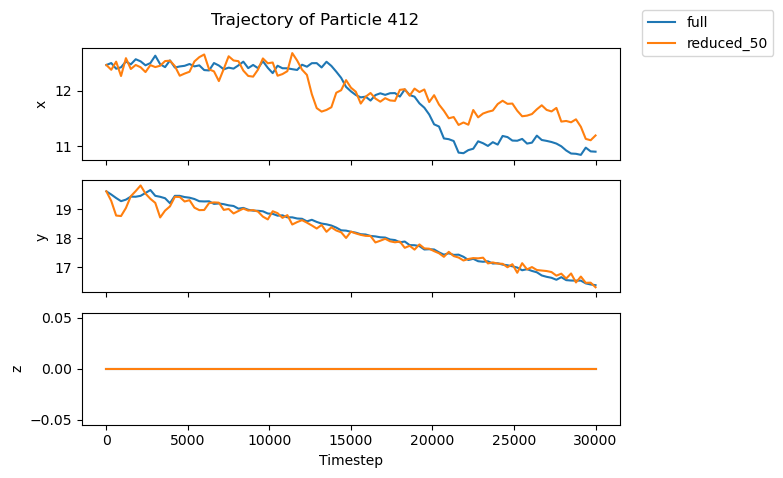

In [47]:
# plot atom trajectory

cols = ["x", "y", "z"]
ax = []

fig = plt.figure(tight_layout=True)
plt.suptitle(f"Trajectory of Particle {a + 1}")

for i in range(3):
  ax.append(fig.add_subplot(3,1,i + 1))
  for model in models.values():
    ax[i].plot(model.time(), model.atom(a + 1, cols[i]))
  ax[i].set_ylabel(cols[i],)
  if (i != 2): ax[i].tick_params('x',labelbottom=False)
ax[i].set_xlabel("Timestep")

fig.align_xlabels(ax)
fig.legend(models.keys(), loc='upper left', bbox_to_anchor=(1,1))

plt.show()

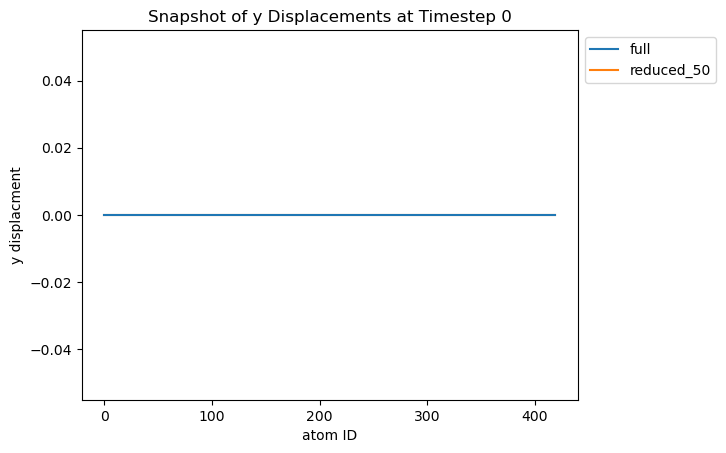

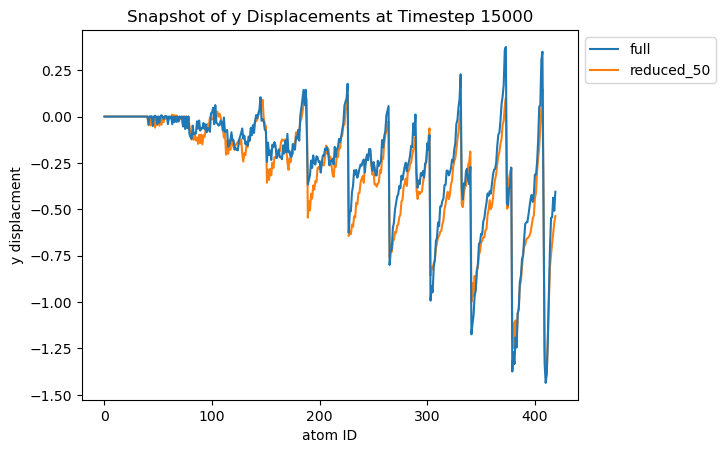

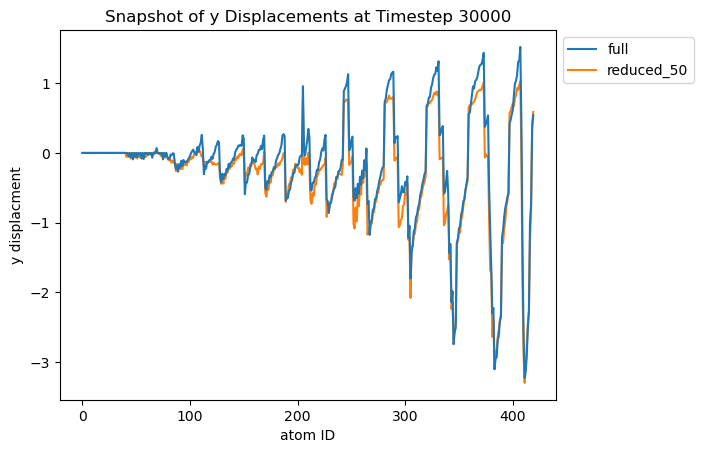

In [48]:
# plot atom displacements for different models

col = "y"

for i in snapshots_indices:

  labels = []

  t = models['full'].time()[i]

  for name, model in models.items():
    try:
      if name == 'full': zorder = 100
      else: zorder = 0
      z2 = np.array(model.vecs(t, col)) - np.array(model.vecs(0, col))
      ax, = plt.plot(z2, zorder = zorder)
      labels.append(name)
    except NameError:
      print("Skipped model", name)
      continue

  plt.legend(labels,loc='upper left', bbox_to_anchor=(1,1))
  plt.xlabel("atom ID")
  plt.ylabel(f"{col} displacment")
  plt.title(f"Snapshot of {col} Displacements at Timestep {t}")
  plt.show()

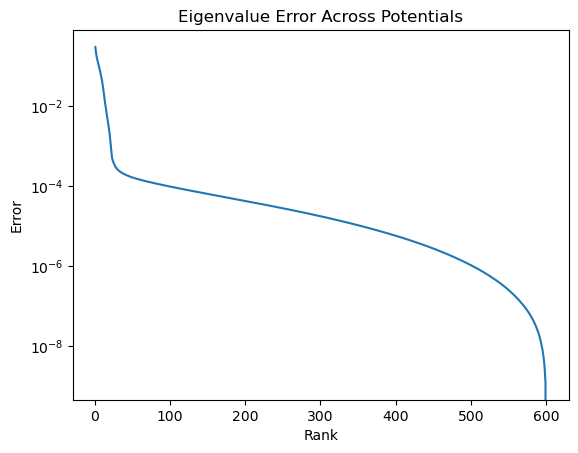

In [49]:
# graph eigenvalue error

display_ranks = 'all'

for pot in potentials:
  num_lines = sum(1 for _ in open(phi_format.format(pot)))
  eigvals = np.power(np.loadtxt(phi_format.format(pot), skiprows=num_lines - 1),2)

  if display_ranks == "all":
    display_ranks = eigvals.size

  plt.plot(np.arange(display_ranks) + 1, (1 - np.cumsum(eigvals)[0:display_ranks]/np.sum(eigvals)))

plt.yscale('log')
plt.title("Eigenvalue Error Across Potentials")
plt.xlabel("Rank")
plt.ylabel("Error")

plt.show()

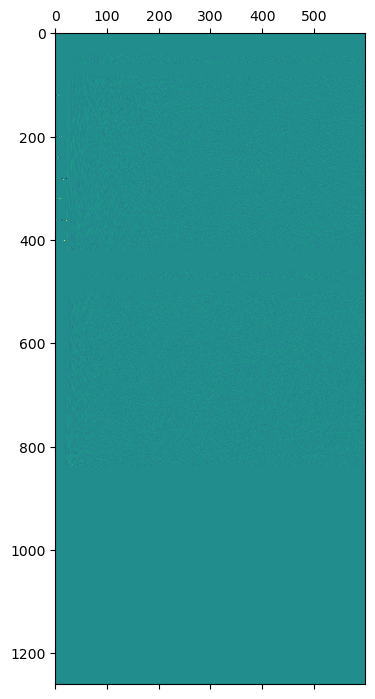

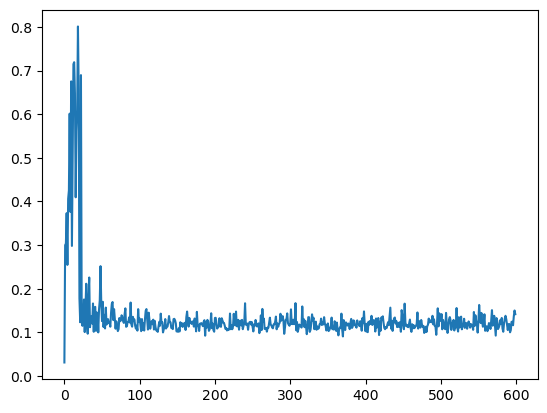

In [50]:
phi_matrix = np.loadtxt(phi_format.format("lj"), max_rows=num_lines - 3)

plt.matshow(phi_matrix, aspect='auto')
plt.show()

plt.plot(phi_matrix.max(axis=0))
plt.show()

In [51]:
# Define error-related functions

def error(model):
    x = models['full'].names["x"]
    y = models['full'].names["y"]
    z = models['full'].names["z"]

    snapshot_errors = []
    full_positions = []

    for i in np.arange(models['full'].nsnaps):

        # get atom positions
        full_position = models['full'].snaps[i].atoms[:,[x,y,z]]
        estimate_position = model.snaps[i].atoms[:,[x,y,z]]

        # calculate snapshot error (L2) and save positions
        snapshot_errors.append(np.linalg.norm(full_position - estimate_position, axis=1))
        full_positions.append(np.linalg.norm(full_position, axis=1))

    # calculate average error
    average_snapshot_error = np.average(np.array(snapshot_errors), axis=0)
    average_positions = np.average(np.array(full_positions), axis=0)

    l2_error = np.linalg.norm(average_snapshot_error)/np.linalg.norm(average_positions)

    return l2_error, average_snapshot_error

def loss(model):
    return error(model)[0]

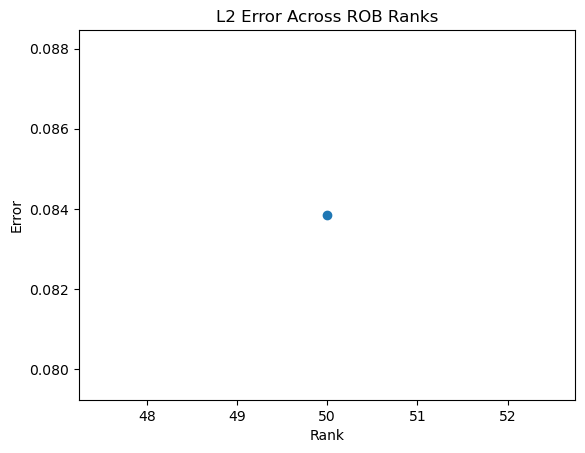

In [52]:
# graph L2 error

errors = []

for n in orders:
    try:
        errors.append(loss(models[f"reduced_{n}"]))
    except IndexError:
       print("Could not calculate error for order", n)
       errors.append(np.inf)

plt.plot(orders, errors, color='k')
plt.scatter(orders, errors, zorder=10)
plt.xlabel("Rank")
plt.ylabel("Error")
plt.title("L2 Error Across ROB Ranks")

plt.show()

In [53]:
# calculate and print means

model = models['full']

atomid = model.names["id"]
x = model.names["x"]
y = model.names["y"]
z = model.names["z"]

means = np.zeros_like(model.snaps[0].atoms[:,[atomid,x,y,z]])

for i in np.arange(model.nsnaps):
  means += model.snaps[i].atoms[:,[atomid,x,y,z]]

means /= model.nsnaps
means_flat = means[:,1:].flatten(order='F')

# np.savetxt("means.txt",means_flat.T, "%.16F")

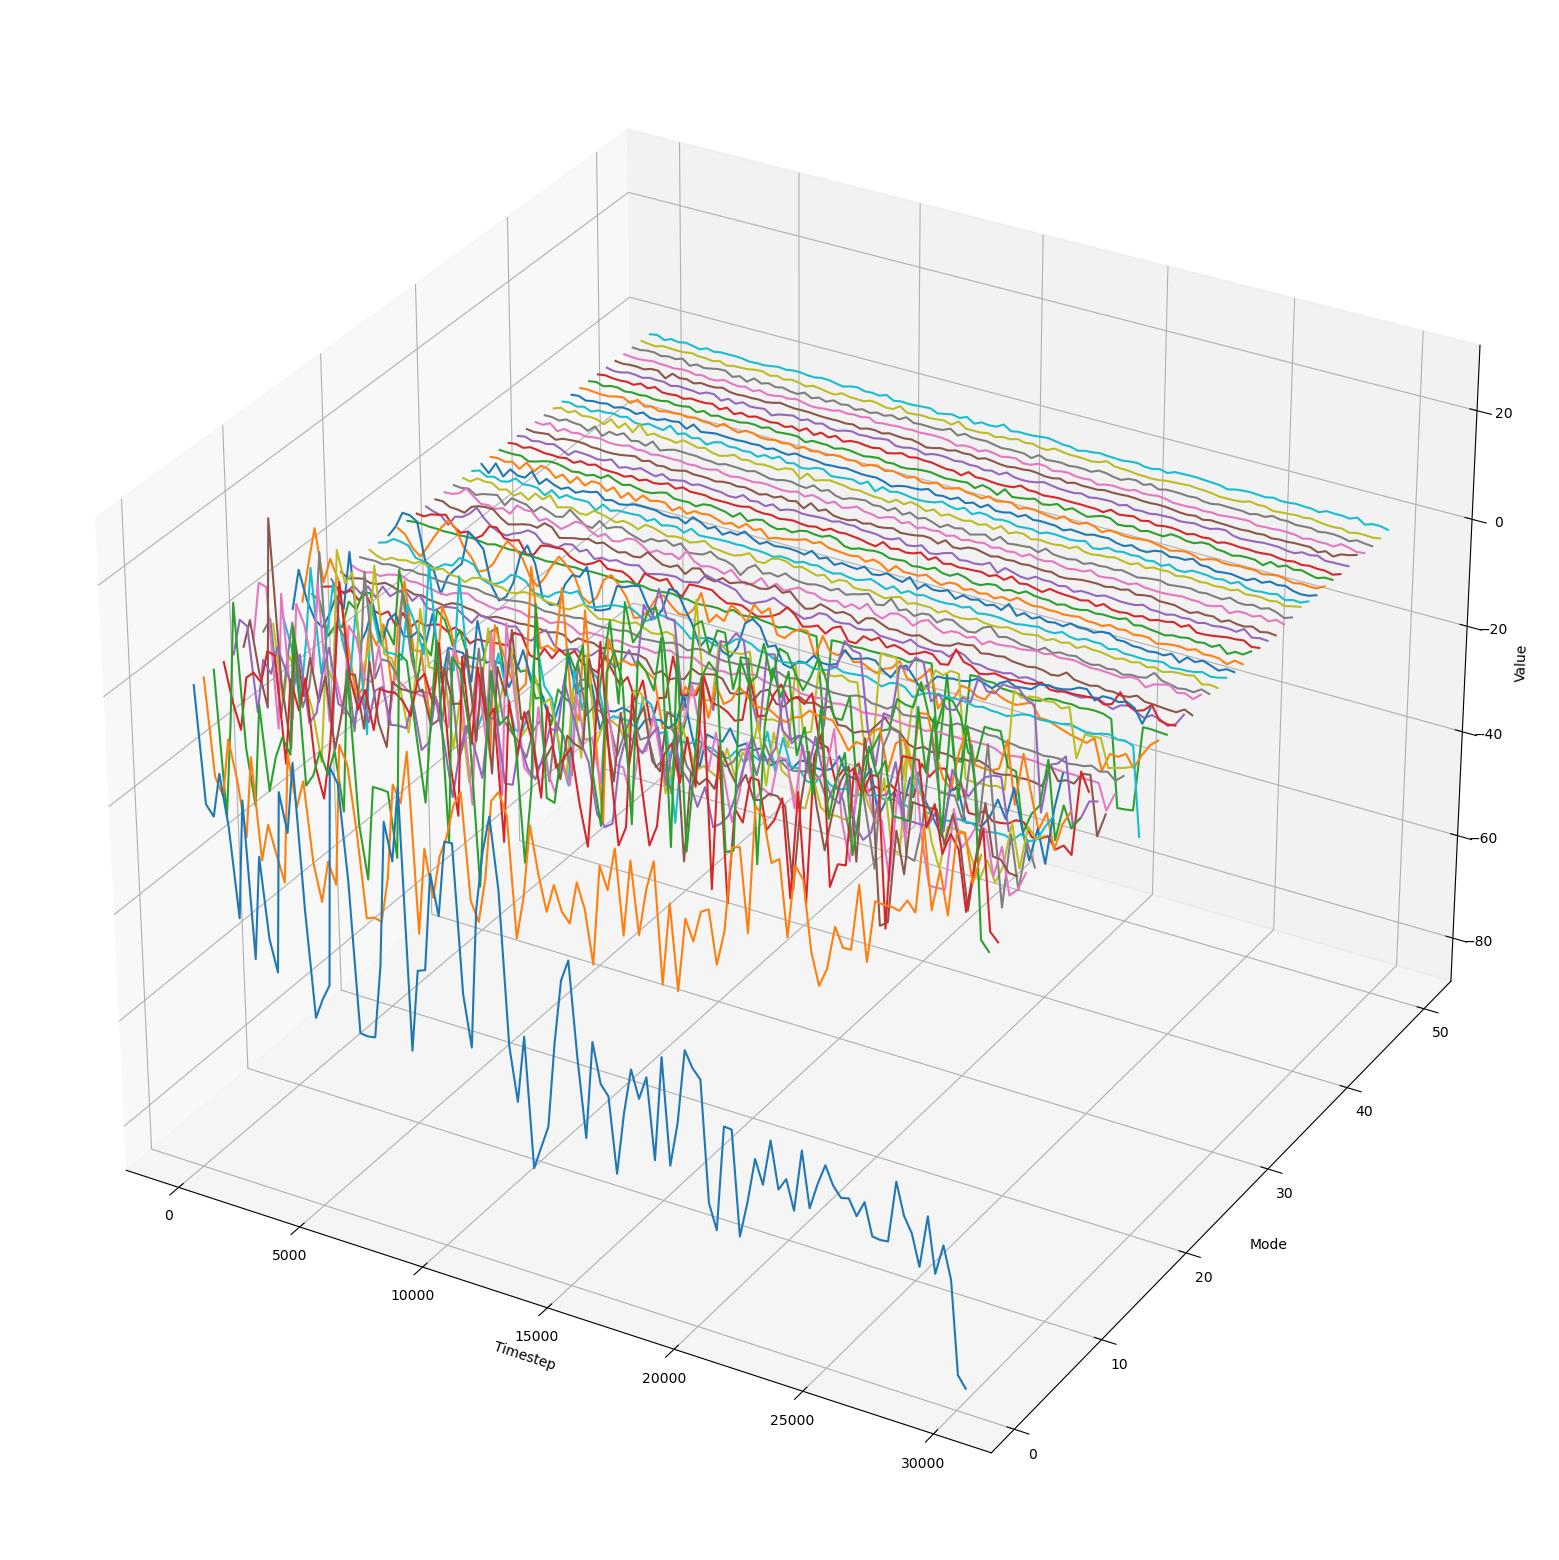

In [80]:
# graph reduced variables

n = 50
y = np.loadtxt("dump.test").reshape((-1,n + 1,2))
t = models[f'reduced_{n}'].time()

fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(projection = '3d')
for i in np.arange(1, n+1): 
  ax.plot(t, np.full(len(t), i),y[:,i,1],zorder=-i)

# ax.set_title(f"Timestep: {t}")
ax.set_xlabel('Timestep')
ax.set_ylabel('Mode')
ax.set_zlabel('Value')

plt.show()

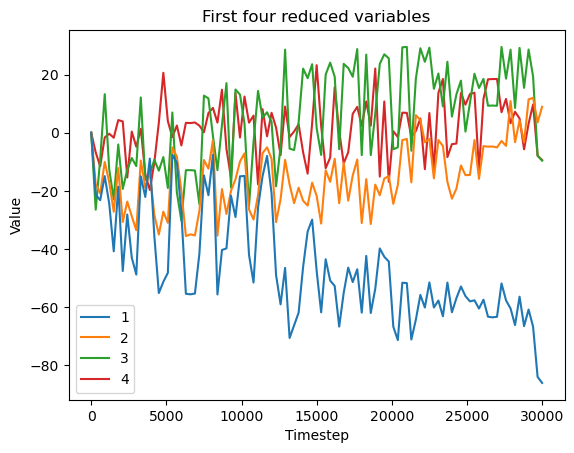

In [90]:
# graph reduced variables

n = 50
y = np.loadtxt("dump.test").reshape((-1,n + 1,2))
t = models[f'reduced_{n}'].time()

fig = plt.figure()
ax = fig.add_subplot()
for i in np.arange(1, 5): 
  ax.plot(t, y[:,i,1],zorder=-i)

# ax.set_title(f"Timestep: {t}")
ax.set_xlabel('Timestep')
ax.set_ylabel('Value')
plt.legend(np.arange(1,5))
plt.title("First four reduced variables")

plt.show()

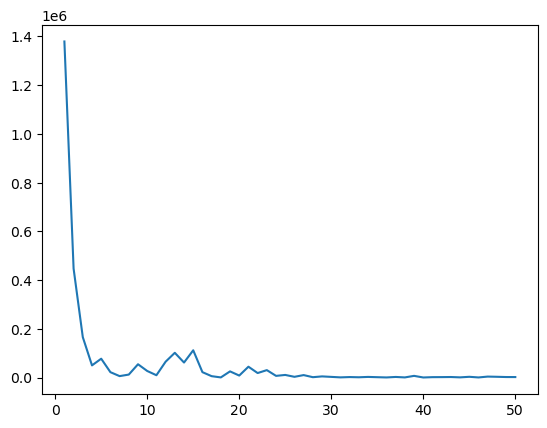

In [82]:
# graph integral over time of each reduced variable by mode

plt.plot(np.arange(1, n+1), np.abs(np.sum(y[:,1:,1] * t[-1] / len(t),axis=0)))
plt.show()